<a href="https://colab.research.google.com/github/leamarcec/Traffic_sign_classification/blob/main/klasifikacija_prometnih_znakova_model3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import os
import zipfile

zip_ref = zipfile.ZipFile('/content/drive/MyDrive/images.zip', 'r')
zip_ref.extractall('/tmp')
zip_ref.close()
len(os.listdir('/tmp/images/'))

6

In [ ]:
base_dir = '/tmp/images/'

train_directory = os.path.join(base_dir, 'Train')

validation_directory = os.path.join(base_dir, 'Test')

In [ ]:
# Direktorij sa trening slikama koje predstavljaju znakove izricitih naredbi
train_class11_dir = os.path.join(train_directory, 'znakovi-izricitih-naredbi')

# Direktorij sa trening slikama koje predstavljaju znakove obavijesti
train_class22_dir = os.path.join(train_directory, 'znakovi-obavijesti')

# Direktorij sa trening slikama koje predstavljaju znakove opasnosti
train_class33_dir = os.path.join(train_directory, 'znakovi-opasnosti')

# Direktorij sa test slikama koje predstavljaju znakove izricitih naredbi
test_directory1 = os.path.join(validation_directory, 'znakovi-izricitih-naredbi')

# Direktorij sa test slikama koje predstavljaju znakove obavijesti
test_directory2 = os.path.join(validation_directory, 'znakovi-obavijesti')

# Direktorij sa test slikama koje predstavljaju znakove opasnosti
test_directory3 = os.path.join(validation_directory, 'znakovi-opasnosti')

In [ ]:
print('Total number of training images of traffic signs with explicit commands:', len(os.listdir(train_class11_dir)))
print('Total number of training images of traffic signs with road notifications:', len(os.listdir(train_class22_dir)))
print('Total number of training images of danger traffic signs:', len(os.listdir(train_class33_dir)))

print('Total number of test images of traffic signs with explicit commands:', len(os.listdir(test_directory1)))
print('Total number of test images of traffic signs with road notifications:', len(os.listdir(test_directory2)))
print('Total number of test images of danger traffic signs:', len(os.listdir(test_directory3)))

Total number of training images of traffic signs with explicit commands: 8856
Total number of training images of traffic signs with road notifications: 3240
Total number of training images of danger traffic signs: 4428
Total number of test images of traffic signs with explicit commands: 1698
Total number of test images of traffic signs with road notifications: 123
Total number of test images of danger traffic signs: 218


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model

from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      # sklairanje slika
      rescale=1./255,

      #rotiranje 20%
      rotation_range=20,

      # random razvlacenje u sirinu za 20%
      width_shift_range=0.2,

      # random razvlacenje u visinu 20%
      height_shift_range=0.2,

      #okretanje slike horizontalno
      horizontal_flip=True
      )

# sklairanje slika
validation_datagen = ImageDataGenerator(
      rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_directory,

        # nove postavljene dimenzije slika
        target_size=(300, 300),

        # velicina mini batcha
        batch_size=32,

        # buduci da postoje tri klase, nije moguce postaviti class_mode na binary kao u primjeru
        # Horse or Human, vec mora biti categorical
        # izvor: https://stackoverflow.com/questions/59439128/what-does-class-mode-parameter-in-keras-image-gen-flow-from-directory-signify
        class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(validation_directory,
        target_size=(300, 300),
        batch_size=32,
        class_mode='categorical')

Found 16524 images belonging to 3 classes.
Found 2039 images belonging to 3 classes.


In [ ]:
import tensorflow as tf

model = tf.keras.models.Sequential([

    # Prvi konvolucijski sloj
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(300, 300, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    # Drugi konvolucijski sloj
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.MaxPooling2D(2,2),

    # Treci konvolucijski sloj
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.25),

    # Skriveni sloj
    tf.keras.layers.Dense(512, activation='relu'),

    tf.keras.layers.Dense(3, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 298, 298, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 149, 149, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 147, 147, 32)      4640      
                                                                 
 dropout (Dropout)           (None, 147, 147, 32)      0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 73, 73, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 71, 71, 64)        1

Stvorena je neuronska mreža s manje slojeva od prethodne, također broj epoha će biti znatno manji, kao i broj koraka po svakoj od njih. Želi se vidjeti kako se model ponaša sa smanjenim resursima u odnosu na prethodna dva modela.

In [ ]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint
from keras import optimizers
optimizer = keras.optimizers.Adam(learning_rate=1e-3)
loss_func = keras.losses.CategoricalCrossentropy()

model.compile(loss="categorical_crossentropy",
             optimizer="rmsprop",
             metrics=["accuracy"])

Za razliku od prethodnih primjera ovdje je korišten optimizator RMSProp. Iako se za optimizator Adam smatra da je najpogodniji za manje modele, na ovom primjeru modela želi se vidjeti ponašanje u ne tako idealnim uvjetima. Iako lošiji izbor od Adama, RMSProp ima svojih predosti, a radi po principu da dodaje decay rate, tj. umanjuje kvadrat gradijenta (izvor: vlastite bilješke s predavanja).

U sljedećih nekoliko linija koda znatno će se promijeniti neki parametri u odnosu na prethodna dva modela. Želi se vidjeti hoće li model uspjeti doseći zadovoljavajuću razinu točnosti koristeći hiperparametre koji možda nisu najbolji izbor za dani problem, a također znatno će se smanjiti broj epoha i broj koraka po svakoj od njih.

In [ ]:
history = model.fit(train_generator,
                    validation_data=validation_generator,
                    steps_per_epoch=5,
                    epochs=5,
                    validation_steps=5,
                    batch_size=32,
                    verbose=1)

Epoch 1/5
5/5 [==============================] - 24s 5s/step - loss: 18.2342 - accuracy: 0.3625 - val_loss: 0.6286 - val_accuracy: 0.8625
Epoch 2/5
5/5 [==============================] - 23s 5s/step - loss: 1.2558 - accuracy: 0.5125 - val_loss: 1.2483 - val_accuracy: 0.0938
Epoch 3/5
5/5 [==============================] - 25s 5s/step - loss: 1.0540 - accuracy: 0.4750 - val_loss: 1.1217 - val_accuracy: 0.1562
Epoch 4/5
5/5 [==============================] - 23s 5s/step - loss: 1.0453 - accuracy: 0.4688 - val_loss: 0.8799 - val_accuracy: 0.8813
Epoch 5/5
5/5 [==============================] - 23s 5s/step - loss: 0.8662 - accuracy: 0.6187 - val_loss: 0.8003 - val_accuracy: 0.8313


**TUMAČENJE REZULTATA**
Može se vidjeti da je točnost znatno manja nakon provođenja svih zadanih epoha nego u modelu 2. U prvoj epohi gubitak je izrazito velik što svakako nije zadovoljavajući rezultat, no međutim u posljednoj epohi taj gubitak se znatno smanjio. Točnost je također na početku izrazito niska (nije mnogo veća u odnosu na slučajni odabir), ali se u zadnjoj epohi povećava.

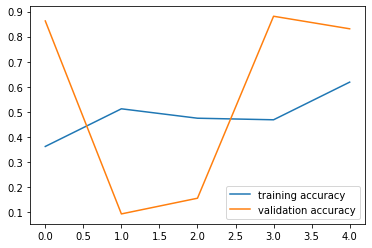

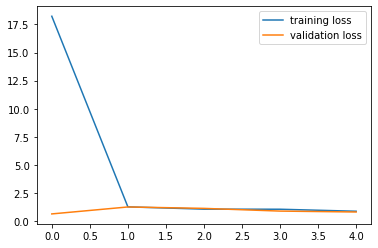

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history["accuracy"],label="training accuracy")
plt.plot(history.history["val_accuracy"],label="validation accuracy")
plt.legend()
plt.show();

plt.plot(history.history["loss"],label="training loss")
plt.plot(history.history["val_loss"],label="validation loss")
plt.legend()
plt.show();

**GRAFIČKI PRIKAZ REZULTATA**
U odnosu na prethodne modele vidi se da se prikazi točnosti trening i test skupa nisu nikako zadovoljavajući. Velike su oscilacije između njih te se vidi da mogel solidno generalizira na trening skupu, ali testni skup ima velikih oscilacija.

**ZAKLJUČAK**
Odabir prikladnih hiperparametara ključan je za stvaranje dobrog modela. Na konkretan problem nije moguće postaviti bilo koji optimizator, niti je poželjno stvarati vrlo plitku neuronsku mrežu. Također, potreban je veći broj epoha za treniranje kako bi model bio što napredniji. Ovaj model je primjer ne tako dobrog rješenja za zadani problem.

In [ ]:
model_json = model.to_json()
with open("model3.json", "w") as json_file:
  json_file.write(model_json)

model.save_weights('model3.h5')

!cp model3.h5 /content/drive/MyDrive